# AnyoneAI - Project II

# Making Estimations with our NBA dataset

In our first project, we learn how to create our own datasets by using a public API, Python and Pandas. We're now going to explore how to make predictive models for regression and classification tasks using ScikitLearn

The goals of this project are:
- Learn how to define a prediction task
- Selecting evaluation metrics and baseline models
- Perform feature engineering and standarization
- Training and using predictive models: Univariable and Multivariate Linear Regression, Classification
- Understand how Gradient Descent works by implementing a Linear Regressor in python

## Using Regression Models to Estimate players Salaries

A player's salary can be explained by a lot of factors: 

- Years in the league: NBA contracts are limited in price, players have caps on how much money they make depending on their years playing in the league
- Age: Highly correlated to the previous one, NBA players have a minimun age of 19 years
- Draft position: players out of USA universities are selected each year through a process called draft, in which each team selects a player in a predefined order for 2 rounds (meaning only 60 players are drafted each year). A rookie contract value depends on the draft position. (Undrafted players have to negotiate a salary independently)
- Performance in statistical categories: after the rookie contract, players can negotiate freely with teams, and usually statistical categories like points, rebounds and assists are extremely important.  
- Team: Even though there are limits to what all teams can expend in players salary, they all allocate their resources differently, and can be more willing to pay the penalties incurred by exceeding those limitations.
- Year in which the contract was signed: the mininum and maximum values of contracts possibles in the NBA changes depending on league revenue (television contracts, sponsorships, etc), so if the amount of money the teams make increases, players can negotiate bigger contracts.
- Intangibles: players can be valued also in things that are not easily translated to a statistic, good defensive players might not always have great stats but can be extremely important for a team, the same can be said about veteran players that help young ones to learn and are good locker-room guys.

But we're going to take a simplified approach, we'll try to use the data we already have to make the best estimator possible, and then we will analyze what went right and what could've gone wrong with our results.

In [ ]:
import pandas as pd
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
import itertools
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_absolute_error, accuracy_score, precision_recall_fscore_support
from sklearn.linear_model import SGDRegressor, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from imblearn.over_sampling import SMOTE 

def r2c(X):
  return X.values.reshape(-1, 1)

### Analyzing our data

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/project2_players_df.csv")
data.dropna(subset=["PTS"], inplace=True)
data.head()

,PERSON_ID,PLAYER_NAME,TEAM_NAME,POSITION,HEIGHT,WEIGHT,COUNTRY,BIRTHDATE,SEASON_EXP,DRAFT_NUMBER,GP,MIN,PTS,REB,AST,STL,BLK,GAME_DATE,Salary,AGE
0,1630173,Precious Achiuwa,Raptors,Forward,203,102,Nigeria,1999-09-19,1,20,115.0,17.3,6.5,5.1,0.8,0.4,0.5,2022-03-06,2711280,"22 years, 5 months, 25 days"
1,203500,Steven Adams,Grizzlies,Center,211,120,New Zealand,1993-07-20,8,12,648.0,26.8,9.3,7.9,1.4,0.9,0.9,2022-03-06,17073171,"28 years, 7 months, 24 days"
2,1628389,Bam Adebayo,Heat,Center,206,116,USA,1997-07-18,4,14,326.0,28.0,13.2,8.2,3.5,1.0,0.9,2022-03-07,28103550,"24 years, 7 months, 26 days"
3,1630583,Santi Aldama,Grizzlies,Forward,211,98,Spain,2001-01-10,0,30,27.0,10.2,3.3,2.4,0.5,0.1,0.3,2022-03-06,1994520,"21 years, 2 months, 6 days"
4,200746,LaMarcus Aldridge,Nets,Center,211,113,USA,1985-07-19,15,2,1073.0,33.7,19.1,8.1,1.9,0.7,1.1,2022-03-06,2641691,"36 years, 7 months, 25 days"


Let's have another look at our previously generated dataset. 

1.1. Plot all players statistics ("PTS", "REB", "AST","STL","BLK") against salary

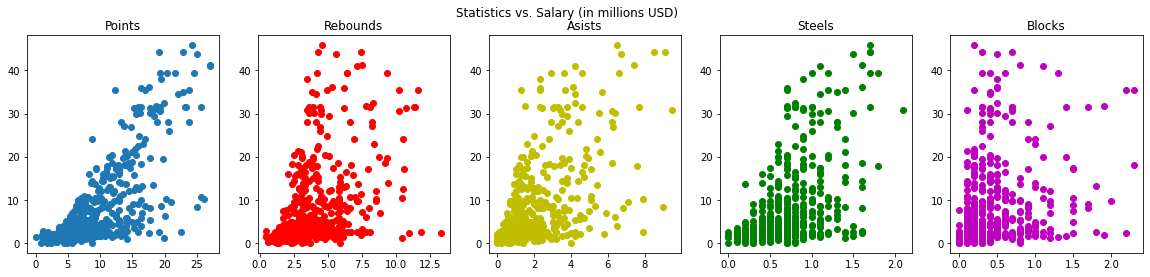

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20,4))
ax1.scatter(data["PTS"], data["Salary"]/1000000)
ax1.set_title("Points")
ax2.scatter(data["REB"], data["Salary"]/1000000, color="r")
ax2.set_title("Rebounds")
ax3.scatter(data["AST"], data["Salary"]/1000000, color="y")
ax3.set_title("Asists")
ax4.scatter(data["STL"], data["Salary"]/1000000, color="g")
ax4.set_title("Steels")
ax5.scatter(data["BLK"], data["Salary"]/1000000, color="m")
ax5.set_title("Blocks")
fig.suptitle("Statistics vs. Salary (in millions USD)")
plt.show()

1.2. What can we say about these distributions?

### Most of the features don't have a great corelation with the salary. At first sight, we can guess that the points feature could be a good fit for the model.

### Splitting the Dataset

1.3. Split the dataset into train and testing sets. Use the Sklearn function for train/test splitting. Make sure to set the random state for reproducibility.

In [ ]:
X = data.drop(columns="Salary")
y = data.Salary
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)

### Baseline Model and Evaluation Metric

In every project, we need a baseline model that implements a very simple algorithm or heuristic so we can compare our results with it. 
In this case, we could create a function that always returns the average player salary, evaluate that, and then compare the result with our modeling to see if we are improving. 

We need an evaluation metric to see how well our models fit the data. For this project we will use [Mean Absolute Error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html#sklearn.metrics.mean_absolute_error) as our regression evaluation metric, because it is a really simple metric to interpret. A lower value means the model performs better. 

For this particular problem, we will always round the value, as we don't need decimals for this task.

1.4. Create a Baseline model class that implements  fit() and predict() methods. As this model will not consider any other variable, the fit method should only receive a list of all players salaries. The predict method should receive and iterable and return a numpy array with the same length but every element should have the same value (the average salary)

In [ ]:
class BaselineModel():
    """A baseline model that always returns the same value, the mean of the players salary in the train data"""
    
    def fit(self, y_train):
        self.mean = np.mean(y_train)      
    
    def predict(self, X):
        return np.array([self.mean] * X.shape[0])

1.5. Evaluate the performance of our BaselineModel on the test set using mean_absolute_error from Sklearn (round the result)

In [ ]:
BL = BaselineModel()
BL.fit(y_train)
y_pred = BL.predict(X_test)
mae_base = round(mean_absolute_error(y_test, y_pred))

print(f"Mean absolute error by BaselineModel is {mae_base}")

Mean absolute error by BaselineModel is 6964043


### Regression with a single variable

You're now going to start modeling data. We will start with a really simple approach, selecting just one variable, and doing a regression to see if we improve upon our baseline.


1.6. Select the variable you think would provide the best fit. Perform feature scaling on this variable using a Sklearn scaler.

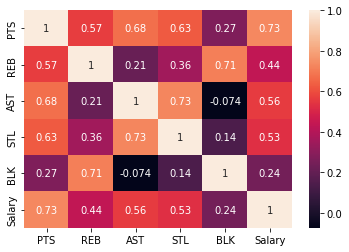

In [ ]:
### First corrobating that the PTS feature is the best fit for this model
sns.heatmap(data[["PTS", "REB", "AST","STL","BLK", "Salary"]].corr(), annot=True)

mms = StandardScaler().fit(r2c(X_train.PTS))
X_train["PTS"] = mms.transform(r2c(X_train.PTS))
X_test["PTS"] = mms.transform(r2c(X_test.PTS))

1.7. Train a model with [SGDRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html) from Sklearn using the default parameters. Evaluate the model's performance on the test set using the selected metric.

 Mean absolute error by SGDRegressor (default) is 4500880


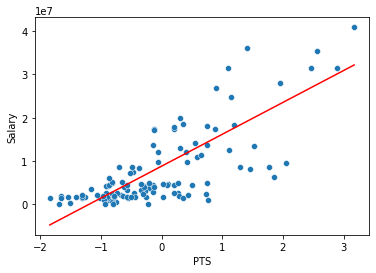

In [ ]:
sgd_reg = SGDRegressor(random_state=100)
sgd_reg.fit(r2c(X_train.PTS), y_train)
y_pred_sgd = sgd_reg.predict(r2c(X_test.PTS))
mae_def = round(mean_absolute_error(y_test, y_pred_sgd))

print(f" Mean absolute error by SGDRegressor (default) is {mae_def}")

sns.scatterplot(x=X_test.PTS, y=y_test)
sns.lineplot(x=X_test.PTS, y=y_pred_sgd, color="r")

1.8. Read the Sklearn documentation, and write a function that tries different configurations for the hyperparameters for training: epochs, learning rate and alpha. For each combination of parameters, evaluate the trained algorithm on the test set, then save the results of each hyperparameter combination, finally select the one that has the best MAE (meaning the lowest number) and print the combination and the MAE.

In [ ]:
def search_best_hyperparameters(max_iter, eta0):
### Initiating in 0 to start calculating mae
### and keep the lower value while looping
### (with the associated hyperparameters)
  result = {"hyperparameters": {"max_iter": None, "eta0": None}, "mae": None}
  it_numb = len(max_iter) * len(eta0)

  for ite, eta in tqdm(itertools.product(max_iter, eta0), total=it_numb):
    SGDReg = SGDRegressor(random_state=100,  max_iter=ite, eta0=eta)
    SGDReg.fit(r2c(X_train.PTS), y_train)
    y_pred = SGDReg.predict(r2c(X_test.PTS))
    mae = round(mean_absolute_error(y_test, y_pred))

    if (result["mae"] == None) or (result["mae"] > mae):
      result = {"hyperparameters": {"max_iter": ite, "eta0": eta}, "mae": mae}

  return result

In [ ]:
max_iter = [50000, 100000, 150000, 500000]
eta0 = [0.0001, 0.0005, 0.001, 0.005]

result = search_best_hyperparameters(max_iter, eta0)
print(result)

  0%|          | 0/16 [00:00<?, ?it/s]

{'hyperparameters': {'max_iter': 50000, 'eta0': 0.001}, 'mae': 4499396}


1.9. Compare the results of the baseline, the SGDRegressor with default parameters and the one with the best combination of hyperparameters you could find. (replace variables with the ones you used)

In [ ]:
print("Mean Absolute Error for each model:")
print(f"Baseline: {mae_base}")
print(f"Default SGDRegressor: {mae_def}")
print(f"Best SGDRegressor: {result['mae']}")

Mean Absolute Error for each model:
Baseline: 6964043
Default SGDRegressor: 4500880
Best SGDRegressor: 4499396


### Multivariate Linear Regression

To improve our model, we will add more features to it. We will have to do some processing to our dataset to be able to use the data.
We'll start with the following variables:

- Points
- Rebounds
- Assists
- Blocks
- Experience
- Position
- Draft Number


1.10. Create a copy of the dataset generated in the first project that only has the following columns (and player id as an index):

["PTS", "REB", "AST", "BLK", "SEASON_EXP", "POSITION", "DRAFT_NUMBER", "TEAM_NAME", "SALARY"]

In [ ]:
dataset = data.copy()
dataset = dataset[["PTS","REB","AST","BLK","SEASON_EXP","POSITION","DRAFT_NUMBER","TEAM_NAME","Salary"]]

#### Feature Engineering

1.11. Binning the DRAFT_NUMBER feature. Draft position directly impacts salaries during the first few years, but second round players and undrafted players don't have guaranteed contracts. So we're gonna divide the bins like this: 

       - 1 to 15: firstround_lottery
       - 15 to 30: firstround_non_lottery
       - 30 to 60: second_round
       - Undrafted: undrafted
       
Create a new column named DRAFT using these 4 categories. Drop the draft number column.

In [ ]:
### Filling NaN with "Undrafted" / Replacing those with "0" / Changing type to int in order to process it in pd.cut()
dataset["DRAFT_NUMBER"].fillna("Undrafted", inplace=True)
draft_number = dataset["DRAFT_NUMBER"].replace("Undrafted", "0").astype(int)

draft_bins = [0, 1, 15, 30, 60]
draft_labels = ["undrafted", 
                "firstround_lottery", 
                "firstround_non_lottery", 
                "second_round"]

dataset["DRAFT"] = pd.cut(draft_number, bins=draft_bins, 
                          labels=draft_labels, include_lowest=True)

dataset.drop(columns="DRAFT_NUMBER", inplace=True)

1.12. Encode the categorical features: DRAFT, POSITION and TEAM_NAME

In [ ]:
dataset = pd.get_dummies(dataset, columns=["DRAFT", "POSITION", "TEAM_NAME"], 
                         drop_first=True)

#### Modeling

1.13. Split the dataset into train and test

In [ ]:
dataset_X = dataset.drop(columns="Salary")
dataset_y = dataset["Salary"]
dataset_X_train, dataset_X_test, dataset_y_train, dataset_y_test = train_test_split(dataset_X, dataset_y, test_size=0.25, random_state=100)

1.14. Perform feature scaling in all the numerical features ("PTS", "REB", "AST", "BLK", "SEASON_EXP") except for draft number

In [ ]:
mms = StandardScaler()
scale_col = ["PTS", "REB", "AST", "BLK", "SEASON_EXP"]

for col in scale_col:
  dataset_X_train[col] = mms.fit_transform(dataset_X_train[[col]])
  dataset_X_test[col] = mms.transform(dataset_X_test[[col]])

1.15. Write a function to train a SGDRegressor model with the new dataset, trying different hyperparameters, and selecting the one that performs the best.

In [ ]:
def search_best_hyperparameters_multi(X_train, X_test, y_train, y_test, 
                                      max_iter, eta0):
### Initiating hyperparameters in None to start calculating mae,
### comparing with the mae value store in result["mae"] 
### (None in the first iteration) and keep the lower value while looping
### (with the associated hyperparameters)
  result = {"hyperparameters": {"max_iter": None, "eta0": None}, "mae": None}

  it_numb = len(max_iter)*len(eta0)

  for ite, eta in tqdm(itertools.product(max_iter, eta0), 
                             total=it_numb):

    SGDReg = SGDRegressor(random_state=100,  max_iter=ite, eta0=eta)
    SGDReg.fit(X_train, y_train)
    y_pred = SGDReg.predict(X_test)
    mae = round(mean_absolute_error(y_test, y_pred))

    if (result["mae"] == None) or (result["mae"] > mae):
      result = {"hyperparameters": {"max_iter": ite, "eta0": eta}, 
                "mae": mae}
  return result

1.16. How did the model performed compared to our univariate models? 

In [ ]:
max_iter = [50000, 100000, 150000, 500000]
eta0 = [0.0001, 0.0005, 0.001, 0.005]

result_multi = search_best_hyperparameters_multi(dataset_X_train, dataset_X_test, 
                                                 dataset_y_train, dataset_y_test, 
                                                 max_iter, eta0)
print(result_multi)

  0%|          | 0/16 [00:00<?, ?it/s]

{'hyperparameters': {'max_iter': 50000, 'eta0': 0.0001}, 'mae': 4645386}


In [ ]:
print("Mean Absolute Error for each model:")
print(f"Baseline: {mae_base}")
print(f"Default SGDRegressor: {mae_def}")
print(f"Best SGDRegressor: {result['mae']}")
print(f"Best multivariate SGDRegressor: {result_multi['mae']}")

Mean Absolute Error for each model:
Baseline: 6964043
Default SGDRegressor: 4500880
Best SGDRegressor: 4499396
Best multivariate SGDRegressor: 4645386


### DecisionTreeRegressor

It is possible that this problem might not be easily resolvable by a linear model, or that there could be better types of algorithms to tackle it. As an example, let's try with a very used algorithm, a Decision Tree.



1.17. Create new model using [DecisionTreeRegressor](https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html) from scikit learn. We will use again all variables, and try different configuration for the following hyperparameters:

- max_depth
- min_samples_leaf
- max_features

These are all regularization hyperparameters for this algorithm. Read the documentation to get a better grasp of what each one does.

In [ ]:
def search_best_hyperparameters_DTR(X_train, X_test, y_train, y_test, 
                          max_depth, min_samples_leaf, max_features):

  result = {"hyperparameters": 
            {"max_depth": None, "min_samples_leaf": None, "max_features": None},
            "mae": None}

  it_numb = len(max_depth) * len(min_samples_leaf) * len(max_features)

  for maxdep, minsl, maxfeat in tqdm(itertools.product(max_depth, 
                                                       min_samples_leaf, 
                                                       max_features), 
                                     total=it_numb):
    
    DTReg = DecisionTreeRegressor(random_state=100, 
                                  max_depth=maxdep, 
                                  min_samples_leaf=minsl, 
                                  max_features=maxfeat)
    DTReg.fit(X_train, y_train)
    y_pred = DTReg.predict(X_test)
    mae = round(mean_absolute_error(y_test, y_pred))

    if (result["mae"] == None) or (result["mae"] > mae):
      result = {"hyperparameters": 
                {"max_depth": maxdep, 
                 "min_samples_leaf": minsl, 
                 "max_features": maxfeat},
                "mae": mae}

  return result

In [ ]:
# List of hyperparameter example values
max_depth = [5, 10, 15, 20, 50]
min_samples_leaf = [2, 10, 20, 50]
max_features = [5, 10]

result_DTR = search_best_hyperparameters_DTR(dataset_X_train, dataset_X_test, 
                                   dataset_y_train, dataset_y_test, 
                                   max_depth, min_samples_leaf, max_features)
print(result_DTR)

  0%|          | 0/40 [00:00<?, ?it/s]

{'hyperparameters': {'max_depth': 5, 'min_samples_leaf': 2, 'max_features': 10}, 'mae': 3897320}


1.18. Compare the results obtained with the best decision tree model against the baseline, default and the best params sgd regressors-

In [ ]:
print("Mean Absolute Error for each model:")
print(f"Baseline: {mae_base}")
print(f"Default SGDRegressor: {mae_def}")
print(f"Best SGDRegressor: {result['mae']}")
print(f"Best multivariate SGDRegressor: {result_multi['mae']}")
print(f"Best DecisionTreeRegressor: {result_DTR['mae']}")

Mean Absolute Error for each model:
Baseline: 6964043
Default SGDRegressor: 4500880
Best SGDRegressor: 4499396
Best multivariate SGDRegressor: 4645386
Best DecisionTreeRegressor: 3897320


### Analyzing our results

Based on what you found, and what you read about players salaries above, answer the following: 

1.19. Which kind of model worked better in this dataset, linear or non linear models? Do you have any hypothesis about why? 

Where we could expect an improvement, there is a clear stepdown (metric goes up in this case) in the mae metric for the multi-feature SGDRegressor. I think both linear models and mae metric are very sensitive to noisy data, wich in this case can be related to non or poorely correlated features with the target.

In conclusion, the DecisionTreeRegressor takes better advantage of multi-featuring predicting like in our case.

1.20. Is there something else we could do to improve our results if wanted to make a more accurate model?

For linear models, we could make a previous analysis of other good corralated features (besides PTS) to filter the noisiest data. It probably won't be as good as decision trees, but it could surely improve the linear regressor results. 

Generally speaking, decision trees seems to need a better setting on hyperparameters since there is a fine line between under and overfitting.

## Star or no Star? Predicting players All-NBA selections

In this section we're going to try to solve a different question:

Can we train a model to predict which players are going to be selected to ALL-NBA teams at the end of the season? This is a [binary classification](https://en.wikipedia.org/wiki/Binary_classification) task, so we're training our first classifier model to solve this problem.

Consider that:

- Being selected as part of the [All-NBA teams](https://en.wikipedia.org/wiki/All-NBA_Team) is different than being selected for [All-Star Game](https://en.wikipedia.org/wiki/NBA_All-Star_Game). 
- You're trying to predict All-NBA selections, which takes place after the regular season but before playoffs start, so we're only going to use players and teams statistics about the regular season (you're not going to consider if the players got to the NBA finals for example). 
- All Star game takes place at the middle point of the regular season, players are selected based on partial season performance, and the general public has 50% of the votes, so it is also a more popularity-based award.
- All-NBA teams are divided in first, second and third teams of 5 players each, divided by position: 2 front court players (guards), 2 backcourt players (forwards) and 1 center.
- As only 15 players are selected to All-NBA teams each year (out of more than 400 qualifying players), our dataset is going to be imbalanced. You're going to have to find a good strategy to deal with this inbalance.

### Analyzing the data

To do this task, you're going to need historical information about All-NBA selections. We'll use a dataset that contains information about players from season starting in 1990 and ending in the 2018-2019 season.
The dataset contains statistics for all players, and a column named "all-nba" that is going to be our target variable, 1 means the player was selected to an All-NBA team that season.


2.1. Load the dataset "all_nba_1990_2017_dataset.csv" from disk, look at the data inside it and print:
- number of rows
- number of seasons
- number of unique players
- number of all-nba selections vs non selected 

In [ ]:
import pandas as pd
all_nba_df = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_1990_2017_dataset.csv", index_col=0)

print(f"number of rows: {all_nba_df.shape[0]}")
print(f"number of seasons: {len(all_nba_df.season.unique())}")
print(f"number of unique players: {len(all_nba_df.player_id.unique())}")
print(f"number of all-nba selections: {list(all_nba_df.all_nba.value_counts())[1]}; vs non selected: {list(all_nba_df.all_nba.value_counts())[0]}")

number of rows: 14825
number of seasons: 39
number of unique players: 2718
number of all-nba selections: 496; vs non selected: 14329


### Splitting the dataset

2.2. Split the dataset in training and test sets. Make sure to keep the distribution of values in the target variable.

Use columns: 'team', 'games', 'games_started', 'mp', 'fg_perc', '3p_perc',
       '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts','all_nba'
       
    

In [ ]:
ANdf_X = all_nba_df[[ 'team', 'games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc', '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts']]
ANdf_y = all_nba_df["all_nba"]
ANdf_X_train, ANdf_X_test, ANdf_y_train, ANdf_y_test = train_test_split(ANdf_X, ANdf_y, stratify=ANdf_y, test_size=0.25, random_state=100)

### Baseline model and Evaluation Metrics

In this oportunity we'll define our baseline model as the model we can train with the minimun amount of work on the dataset. For this you're gonna train a [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) with default parameters, and without doing any preprocessing to our data.

2.3. Let's start with a simple test. What accuracy would we get if we had a baseline model that always predicted 0 (player not selected to all nba)?

In [ ]:
class BaselineModelAllNBA():
    
    def fit(self, y_train):
        self.zero = 0      
    
    def predict(self, X):
        return np.array([self.zero] * X.shape[0])

In [ ]:
BL_AN = BaselineModelAllNBA()
BL_AN.fit(y_train)
y_pred_AN = BL_AN.predict(ANdf_X_test)
score_AN = accuracy_score(ANdf_y_test, y_pred_AN)

print(f"The baseline model has {round(score_AN * 100, 2)} % accuracy")

The baseline model has 96.65 % accuracy


2.4. What does this tells us about the data and the use of accuracy as an evaluation metric?

In this particular case, since the selected players are a very small percentage of all the players entries, the accuracy of the model as to be evaluated in a very sensitive way. 

2.5. Scale all numerical features in the dataset (we will keep this scaling for future modeling, so make sure to do it in place)

In [ ]:
def scaling(scaler, feat):
  scaler = scaler.fit(r2c(feat))
  scaled = scaler.transform(r2c(feat))
  return scaler, scaled

def df_scaling_num(data, scaler):
  
  cols = []
  for col in data.columns:
    if is_numeric_dtype(data[col]) == True:
      cols.append(col)

  data_num = data[cols].copy()
  data_scaled_num = pd.DataFrame(index=data_num.index, columns=data_num.columns)

  for feat in data_num.columns:
    dismiss , data_scaled_num[feat] = scaling(scaler, data_num[feat])

  return data_scaled_num

In [ ]:
ANdf_X_train_scaled = df_scaling_num(ANdf_X_train, StandardScaler())
ANdf_X_test_scaled = df_scaling_num(ANdf_X_test, StandardScaler())

2.6. Train a LogisticRegression with default parameters, use only the numerical features (omit the team information for now). This will be our baseline model. 

In [ ]:
logic_reg = LogisticRegression().fit(ANdf_X_train_scaled, ANdf_y_train)
y_pred_lr = logic_reg.predict(ANdf_X_test_scaled)
score_lr = accuracy_score(ANdf_y_test, y_pred_lr)
print(f"The LogisticRegression model with defaults parameters has {round(score_lr * 100, 2)} % accuracy")

The LogisticRegression model with defaults parameters has 98.27 % accuracy


2.7. Evaluate our baseline model using this metrics: 

    - accuracy
    - precision
    - recall
    - f1

In [ ]:
score_lr = logic_reg.score(ANdf_X_test_scaled, ANdf_y_test)
metrics_lr = precision_recall_fscore_support(ANdf_y_test, y_pred_lr, average="binary")

print(f"accuracy {score_lr}")
print(f"precision {metrics_lr[0]}")
print(f"recall {metrics_lr[1]}")
print(f"f1 {metrics_lr[2]}")

accuracy 0.982735365524683
precision 0.7777777777777778
recall 0.6774193548387096
f1 0.7241379310344828


From now on, you'll be evaluating you model primarily using the F1 Score metric, but we also want to avoid models that have very low recall. 

### Classification

#### Feature engineering

2.8. One hot encode the Team feature. Make sure to drop the original column.

In [ ]:
OHE = OneHotEncoder(sparse=False)

team_encoded = OHE.fit_transform(r2c(ANdf_X_train["team"]))
team_encoded = pd.DataFrame(data=team_encoded, columns=OHE.categories_[0])
ANdf_X_train_scaled_enc = pd.concat([ANdf_X_train_scaled.reset_index(drop=True), team_encoded], axis=1)

team_encoded_test = OHE.transform(r2c(ANdf_X_test["team"]))
team_encoded_test = pd.DataFrame(data=team_encoded_test, columns=OHE.categories_[0])
ANdf_X_test_scaled_enc = pd.concat([ANdf_X_test_scaled.reset_index(drop=True), team_encoded_test], axis=1)

#### Modeling

2.9. Train a logistic regresion model, find the best hyperparameters for: tols, C and max_iter. Try at least 4 values of each parameter. Remember to select based on f1 score, but report also precision and recall. Save the best performing model to use in the next steps.

In [ ]:
def search_best_hyper_LR(X_train, X_test, y_train, y_test, 
                          tol, C, max_iter):

  result = {"hyperparameters": 
            {"tol": None, "C": None, "max_iter": None},
            "metrics": {"precision": None, "recall": None, "f1": None}}

  it_numb = len(tol) * len(C) * len(max_iter)

  for t, c, mi in tqdm(itertools.product(tol, C, max_iter), total=it_numb):
    
    LogReg = LogisticRegression(random_state=100, 
                                  tol=t, 
                                  C=c, 
                                  max_iter=mi)
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    metrics = precision_recall_fscore_support(y_test, y_pred, average="binary")

    if (result["metrics"]["f1"] == None) or (result["metrics"]["f1"] < metrics[2]):
      result = {"hyperparameters": 
                {"tol": t, "C": c, "max_iter": mi},
                "metrics": 
                {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}}

  return result

In [ ]:
tol = [0.01, 0.001, 0.0001, 0.00001, 0.000001]
C = [0.8, 0.9, 1, 1.1, 1.2]
max_iter = [1000, 4000, 16000, 64000]

best_result_LR = search_best_hyper_LR(ANdf_X_train_scaled_enc, ANdf_X_test_scaled_enc, ANdf_y_train, ANdf_y_test, tol, C, max_iter)
best_result_LR

  0%|          | 0/100 [00:00<?, ?it/s]

{'hyperparameters': {'C': 1.2, 'max_iter': 1000, 'tol': 0.01},
 'metrics': {'f1': 0.7445887445887446,
  'precision': 0.8037383177570093,
  'recall': 0.6935483870967742}}

#### Evaluating on New Data

You're now going to evaluate the results on a test dataset that has not being used to train or do hyperparameter tuning, this is sometimes known as a Test set (in this cases the test set used for training is known as validation set, yeah, it's confusing, but you can read about it [here](https://machinelearningmastery.com/difference-test-validation-datasets/))

2.10. Load the dataset [all_nba_2018_dataset.csv](https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_dataset.csv) in one dataframe and [all_nba_2018_selections.csv](https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_selections.csv)) in another, then:

    - Scale the numerical features. Columns season_id, player_id, player_season, player, season and season_start will not be used for prediction, you can keep them but remember not to pass them to the classifier.
    
    - Create the one hot encoded features for team. This step will be complex, as you will have to consider that in the 2018 season there are 30 teams, but the previous dataset contains 40 teams, that is because a lot of teams changed names or cities over the years. You need to add those 10 different team names in this dataset (with all values in 0) to make the classifier work.

In [ ]:
all_nba_2018_df = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_dataset.csv", index_col=0)
all_nba_2018_selections = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_selections.csv", index_col=0)

2.11. Predict and evaluate the model using precision, recall and f1 score. 

In [ ]:
filt_col = ['team', 'games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc', '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts']
AN2018 = all_nba_2018_df[filt_col]

AN2018_scaled = df_scaling_num(AN2018, StandardScaler())
AN2018_enc = OHE.transform(r2c(AN2018["team"]))
AN2018_enc = pd.DataFrame(data=AN2018_enc, columns=OHE.categories_[0])
AN2018_scaled_enc = pd.concat([AN2018_scaled.reset_index(drop=True), AN2018_enc], axis=1)

LogReg = LogisticRegression(random_state=100, 
                            tol=best_result_LR["hyperparameters"]["tol"], 
                            C=best_result_LR["hyperparameters"]["C"], 
                            max_iter=best_result_LR["hyperparameters"]["max_iter"])

LogReg.fit(ANdf_X_train_scaled_enc, ANdf_y_train)
y_pred = LogReg.predict(AN2018_scaled_enc)
metrics = precision_recall_fscore_support(all_nba_2018_selections["all_nba"], y_pred, average="binary")

result_testset = {"accuracy": accuracy_score(all_nba_2018_selections["all_nba"], y_pred), 
          "precision": metrics[0], 
          "recall": metrics[1], 
          "f1": metrics[2]}

In [ ]:
result_testset

{'accuracy': 0.9867924528301887,
 'f1': 0.8108108108108109,
 'precision': 0.6818181818181818,
 'recall': 1.0}

2.12. Analyze the results, what do you think it is happening?

F1 score is lower on the testing dataset and the recall score is 1.
This could happend due to a bad generalisation of the trained model. It could be overfitting.

#### Creating our custom Classifier

One thing to consider in this problem, is that the number of ALl NBA selections is fixed each year, a total of 15 players are always selected. But our current model does not limit the number of positive classified players. So, we will have to wrap our model in a custom classifier that only returns as positive the 15 players with the higher probabilities. 
Fortunately, our chosen model provides access to the underlying probabilities.

2.13. Using the trained model, predict probabilities for all rows in the dataset, and create a new column that has the probability that the player was selected as all nba. Round the probability to 3 decimals.

In [ ]:
AN2018_scaled_enc["probability"] = LogReg.predict_proba(AN2018_scaled_enc)[:, 1]
AN2018_scaled_enc["probability"] = list(map(lambda x : round(x, 3), AN2018_scaled_enc["probability"]))

miss_col = ["season_id", "player_id", "player_season", "player", "season", "season_start"]
AN2018_se = pd.concat([all_nba_2018_df[miss_col].reset_index(drop=True), AN2018_scaled_enc], axis=1)

2.14. Sort the dataset by probabilities and show the 15 players with higher probability to have been selected

In [ ]:
predict_15 = AN2018_se.sort_values(by=["probability"], ascending=False)[:15]
predict_15

,season_id,player_id,player_season,player,season,season_start,games,gamesstarted,mp,fg_perc,...,SAS,SDC,SEA,TOR,TOT,UTA,VAN,WAS,WSB,probability
17,452,83,6,Giannis Antetokounmpo,2018-19,2018,0.874296,1.744976,1.476018,1.236092,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.998
205,5604,1024,10,James Harden,2018-19,2018,1.104851,1.959556,1.915365,0.018697,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.997
257,6841,1240,16,LeBron James,2018-19,2018,0.221057,1.137001,1.739626,0.627394,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.995
125,3273,587,7,Anthony Davis,2018-19,2018,0.259483,1.172764,1.497985,0.690054,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.976
154,4145,740,3,Joel Embiid,2018-19,2018,0.566889,1.458870,1.574871,0.394657,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.954
505,14479,2648,11,Russell Westbrook,2018-19,2018,0.912722,1.780740,1.827495,-0.106623,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.945
149,3908,695,12,Kevin Durant,2018-19,2018,1.104851,1.959556,1.673724,0.725860,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.936
491,14027,2572,8,Nikola Vucevic,2018-19,2018,1.181702,2.031082,1.322247,0.699006,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.923
182,4891,884,9,Paul George,2018-19,2018,1.066425,1.923793,1.926348,-0.017109,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.866
300,8097,1492,8,Kawhi Leonard,2018-19,2018,0.413186,1.315817,1.607822,0.502074,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.817


2.15. Print:

    - Players actually selected from the all_nba_2018_selections dataset,
    - Players actually selected missing from OUR predictions+
    - Players in our predictions not selected 

In [ ]:
selected = all_nba_2018_selections[all_nba_2018_selections["all_nba"] == 1]
print(f"Players actually selected:\n {selected}\n")

missing_id = pd.DataFrame([i for i in selected.player_id if i not in list(predict_15.player_id)], columns=["player_id"])
missing = selected.merge(missing_id, on="player_id", how="inner")
print(f"Players actually selected missing from our predictions:\n{missing}\n")

wrong_selected_id = pd.DataFrame([i for i in predict_15.player_id if i not in list(selected.player_id)], columns=["player_id"])
wrong_selected = predict_15.merge(wrong_selected_id, on="player_id")[["player_id", "player", "probability"]]
print(f"Players in our prediction not selected:\n {wrong_selected}")

Players actually selected:
        player_id                 player  all_nba
453           83  Giannis Antetokounmpo        1
3168         570          Stephen Curry        1
3908         695           Kevin Durant        1
4145         740            Joel Embiid        1
4895         884            Paul George        1
5016         909            Rudy Gobert        1
5399         979          Blake Griffin        1
5604        1024           James Harden        1
6634        1204           Kyrie Irving        1
6857        1240           LeBron James        1
7225        1315           Nikola Jokic        1
8103        1492          Kawhi Leonard        1
8206        1511         Damian Lillard        1
14132       2585           Kemba Walker        1
14479       2648      Russell Westbrook        1

Players actually selected missing from our predictions:
   player_id         player  all_nba
0        570  Stephen Curry        1
1       1204   Kyrie Irving        1
2       1315   Nikol

2.16. Create a class named AllNbaSingleSeasonClassifier that takes a scikit learn model in the constructor, then implements a predict method that returns predictions with only the 15 most probable selections.

In [ ]:
class AllNbaSingleSeasonClassifier():
### model and scaler have to be pre-fitted with the train model
    def __init__(self, model, scaler):
        self._model = model
        self._scaler = scaler
        
    def predict(self, X):
      cols = ['team', 'games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc', '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts']
      X_scaled = df_scaling_num(X[cols], StandardScaler())
      X_enc = self._scaler.transform(r2c(X["team"]))
      X_enc = pd.DataFrame(data=X_enc, columns=self._scaler.categories_[0])
      X_scaled_enc = pd.concat([X_scaled.reset_index(drop=True), X_enc], axis=1)
      X["probability"] = self._model.predict_proba(X_scaled_enc)[:, 1]
      X.sort_values(by=["probability"], ascending=False, inplace=True)
      X["all_nba"] = 0
      X["all_nba"].iloc[:15] = 1
      X.sort_index(inplace=True)

      return X.all_nba

2.17. Use the new classifier to make predictions and evaluate the result with precision, recall and f1

In [ ]:
y_pred_class = AllNbaSingleSeasonClassifier(LogReg, OHE).predict(all_nba_2018_df)
accuracy_class = accuracy_score(all_nba_2018_selections["all_nba"], y_pred_class)
metrics_class = precision_recall_fscore_support(all_nba_2018_selections["all_nba"], y_pred_class, average="binary")

print(f"Accuracy: {accuracy_class}")
print(f"Precision: {metrics_class[0]}")
print(f"Recall: {metrics_class[1]}")
print(f"F1: {metrics_class[2]}")

Accuracy: 0.9849056603773585
Precision: 0.7333333333333333
Recall: 0.7333333333333333
F1: 0.7333333333333333


#### Analyzing our results

2.18. What do you think it is the main problem with this dataset and the way we trained our model?

I guess the main problem is still the unbalance target in the dataset. There is not enough positive samples to train the model an obtain a good prediction. Stratify the split of the train-test dataset may be not enough.

2.19. What do you think we could do to improve our model?

Obtaining more data about selected players over the years and training the dataset considering the season for each selection. We could also consider the position requirement to improve the prediction.

### Optional: Oversampling

2.19. Read about oversampling techniques, for example [SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html). Use this strategy to create synthetic data and retrain our model. Compare the results. 

In [ ]:
sm = SMOTE(random_state=100)
X_res, y_res = sm.fit_resample(ANdf_X_train_scaled_enc, ANdf_y_train)

LogReg_sm = LogisticRegression(random_state=100, 
                            tol=best_result_LR["hyperparameters"]["tol"], 
                            C=best_result_LR["hyperparameters"]["C"], 
                            max_iter=best_result_LR["hyperparameters"]["max_iter"])

LogReg_sm.fit(X_res, y_res)

y_pred_sm = AllNbaSingleSeasonClassifier(LogReg_sm, OHE).predict(all_nba_2018_df)
accuracy_sm = accuracy_score(all_nba_2018_selections["all_nba"], y_pred_sm)
metrics_sm = precision_recall_fscore_support(all_nba_2018_selections["all_nba"], y_pred_sm, average="binary")

print(f"Accuracy: {accuracy_sm}")
print(f"Precision: {metrics_sm[0]}")
print(f"Recall: {metrics_sm[1]}")
print(f"F1: {metrics_sm[2]}")

Accuracy: 0.9849056603773585
Precision: 0.7333333333333333
Recall: 0.7333333333333333
F1: 0.7333333333333333


The results with oversampling show no improvement, they are exactly the same.

## Optional: Developing a Linear Regressor class from scratch

Our last task will be to code a Linear Regression algorithm using Gradient Descent as its optimization algorithm in Python. The structure of the class is presented below, you should use numpy for numerical computation.

3.1. Write a LinearRegression class that implements fit and predict methods, and uses gradient descent as optimization algorithm

In [ ]:
class MyLinearRegressor:

    def __init__(self, epochs=100, learning_rate=0.001, treshold=1000):
        self._epochs = epochs
        self._learning_rate = learning_rate
        self._treshold = treshold

    def _loss_function(self, y_pred, y):
        loss = (1/(2*len(y))) * np.sum((y_pred - y)**2)
        return loss

    def _gradient_descent(self, X, y):
        a = 0
        b = y.mean()
        last_loss = None
        for i in range(self._epochs):
          y_pred = a * X + b
          loss = self._loss_function(y_pred, y)
          if last_loss != None and abs(last_loss - loss) < self._treshold:
            break
          a = a - self._learning_rate * (1 / len(y)) * np.sum((y_pred - y) * X)
          b = b - self._learning_rate * (1 / len(y)) * np.sum(y_pred - y)
          last_loss = loss
        return a, b

    def fit(self, X, y):
        X = X.values
        y = y.values
        self.a, self.b = self._gradient_descent(X, y)
        return self

    def predict(self, X):
        y_out = self.a * X + self.b
        return y_out

3.2. Train a regression model with the data from the first section to calculate players salaries using points per game. Try with a few different values (3 or 4 for each should suffice) for epochs and learning rate parameters, calculate MAE for all results and save the best result along with the parameters values used.

In [ ]:
def search_best_hyperparameters_My_LR(X_train, X_test, y_train, y_test, epochs, learning_rate):

  result = {"hyperparameters": {"epochs": None, "learning_rate": None}, "mae": None}

  it_numb = len(epochs) * len(learning_rate)

  for ep, lr in tqdm(itertools.product(epochs, learning_rate), total=it_numb):
    
    MyLR = MyLinearRegressor(epochs=ep, learning_rate=lr).fit(X_train, y_train)
    y_pred = MyLR.predict(X_test)
    mae = round(mean_absolute_error(y_test, y_pred))

    if (result["mae"] == None) or (result["mae"] > mae):
      result = {"hyperparameters": {"epochs": ep, "learning_rate": lr}, "mae": mae}

  return result

In [ ]:
epochs_values = [100, 1000, 10000]
learning_rate_values = [0.001, 0.0001]

result_MyLR = search_best_hyperparameters_My_LR(dataset_X_train.PTS, dataset_X_test.PTS, dataset_y_train, dataset_y_test, 
                                                epochs=epochs_values, learning_rate=learning_rate_values)
result_MyLR

  0%|          | 0/6 [00:00<?, ?it/s]

{'hyperparameters': {'epochs': 10000, 'learning_rate': 0.001}, 'mae': 4500165}

3.3. Evaluate the model performance on the test set, and compare with the result you obtained using SGDRegressor from scikit-learn.

In [ ]:
print("Mean Absolute Error for each model:")
print(f"Baseline: {mae_base}")
print(f"Default SGDRegressor: {mae_def}")
print(f"Best SGDRegressor: {result['mae']}")
print(f"Best multivariate SGDRegressor: {result_multi['mae']}")
print(f"Best DecisionTreeRegressor: {result_DTR['mae']}")
print(f"Best MyLinearRegressor: {result_MyLR['mae']}")

Mean Absolute Error for each model:
Baseline: 6964043
Default SGDRegressor: 4500880
Best SGDRegressor: 4499396
Best multivariate SGDRegressor: 4645386
Best DecisionTreeRegressor: 3897320
Best MyLinearRegressor: 4500165
